In [1]:
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37275,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:39847,Total threads: 1
Dashboard: /proxy/42975/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:42001,


In [3]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [4]:
#getting the climatology
CSHT_along_clim0=xr.open_dataset('/g/data/v45/wf4500/ASC_project_files/IAF_CSHT_monthly_climatology.nc')
CSHTc=np.tile(np.array(CSHT_along_clim0.binned_cross_slope_heat_trans),[61,1,1])
ZCc=np.tile(np.array(CSHT_along_clim0.zonal_convergence),[61,1,1])
HTc=np.tile(np.array(CSHT_along_clim0.unbinned_heat_transp_across_contour),[61,1,1])
#

In [5]:
CSHT_along_eddy=CSHT_along.resample(time='1M').mean()
CSHT_along_eddy['binned_cross_slope_heat_trans']=CSHT_along_eddy.binned_cross_slope_heat_trans - CSHTc
CSHT_along_eddy['zonal_convergence']=CSHT_along_eddy['zonal_convergence'] - ZCc
CSHT_along_eddy['unbinned_heat_transp_across_contour']=CSHT_along_eddy['unbinned_heat_transp_across_contour'] - HTc

# del CSHTc,ZCc,HTc

In [6]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

#u_along_da_mean.load()
#u_along_da_seasonal.load()
#u_along_da_annual.load()
u_along_da_monthly.load()

<xarray.DataArray 'u_along_contour_binned' (time: 732, st_ocean: 75,
                                            lon_bin_midpoints: 1428)>
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * st_ocean           (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 -278.5 -278.2 ... 78.0 78.25
  * time               (time) datetime64[ns] 1958-01-31 ... 2018-12-31

In [7]:
#session = cc.database.create_session()
exp = '01deg_jra55v140_iaf_cycle3'
rho_0 = 1035.0
# specific heat capacity of sea water:
cp = 3992.1
lat_range = slice(-90,-59)

## Mask for regional 
setting mask for a local region of each regime, Totten for surface, WAP for reversed, Ross for deep
let Totten lon sel = (-247,-234.5) (i= 1)
WAP lon sel = (-90, -60) %%90-60W
Ross lon sel = (-200,-170) (i = 3)


In [8]:
regional_bound = [slice(-247,-234.5),  slice(-90,-60),slice(-200,-170)]

In [9]:
i = 1

In [10]:
labels_regional = np.ones(u_along.lon_bin_midpoints.size)*np.nan
## fill with value of 1,2,3 depending on region. nans otherwise

for rr in range(3):
    s = set(u_along.lon_bin_midpoints.sel(lon_bin_midpoints = regional_bound[rr]).values)
    for ll in range(u_along.lon_bin_midpoints.size):
        if  float(u_along.lon_bin_midpoints.isel(lon_bin_midpoints = ll).values) in s:
            labels_regional[ll] = rr
            
labels_regional

array([nan, nan, nan, ..., nan, nan, nan])

In [11]:
import gc 
client.run(gc.collect)

{'tcp://127.0.0.1:35531': 2122,
 'tcp://127.0.0.1:36985': 2107,
 'tcp://127.0.0.1:37975': 2098,
 'tcp://127.0.0.1:39847': 2127}

In [84]:
CSHT_along.lon_bin_midpoints.sel(lon_bin_midpoints = regional_bound[rr])

<xarray.DataArray 'lon_bin_midpoints' (lon_bin_midpoints: 121)>
array([-200.  , -199.75, -199.5 , -199.25, -199.  , -198.75, -198.5 , -198.25,
       -198.  , -197.75, -197.5 , -197.25, -197.  , -196.75, -196.5 , -196.25,
       -196.  , -195.75, -195.5 , -195.25, -195.  , -194.75, -194.5 , -194.25,
       -194.  , -193.75, -193.5 , -193.25, -193.  , -192.75, -192.5 , -192.25,
       -192.  , -191.75, -191.5 , -191.25, -191.  , -190.75, -190.5 , -190.25,
       -190.  , -189.75, -189.5 , -189.25, -189.  , -188.75, -188.5 , -188.25,
       -188.  , -187.75, -187.5 , -187.25, -187.  , -186.75, -186.5 , -186.25,
       -186.  , -185.75, -185.5 , -185.25, -185.  , -184.75, -184.5 , -184.25,
       -184.  , -183.75, -183.5 , -183.25, -183.  , -182.75, -182.5 , -182.25,
       -182.  , -181.75, -181.5 , -181.25, -181.  , -180.75, -180.5 , -180.25,
       -180.  , -179.75, -179.5 , -179.25, -179.  , -178.75, -178.5 , -178.25,
       -178.  , -177.75, -177.5 , -177.25, -177.  , -176.75, -176.5 , -176.25,
       -176.  , -175.75, -175.5 , -175.25, -175.  , -174.75, -174.5 , -174.25,
       -174.  , -173.75, -173.5 , -173.25, -173.  , -172.75, -172.5 , -172.25,
       -172.  , -171.75, -171.5 , -171.25, -171.  , -170.75, -170.5 , -170.25,
       -170.  ])
Coordinates:
  * lon_bin_midpoints  (lon_bin_midpoints) float64 -200.0 -199.8 ... -170.0

## plotting area

In [14]:
isobath_depth = 1000

In [15]:
lon_along_contour = CSHT_along.lon_along_contour
lat_along_contour = CSHT_along.lat_along_contour

In [51]:
session = cc.database.create_session() 

In [52]:
lat_slice = slice(-80, -59)

# Import bathymetry
hu = cc.querying.getvar(exp, 'hu',session, n=1)

# Select latitude range
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [53]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

In [54]:
labels_regional.size

1428

In [66]:
import gc
client.run(gc.collect)

{'tcp://127.0.0.1:33881': 76,
 'tcp://127.0.0.1:38509': 76,
 'tcp://127.0.0.1:38561': 832,
 'tcp://127.0.0.1:42657': 76}

Text(0.5, 0, 'Latitude')

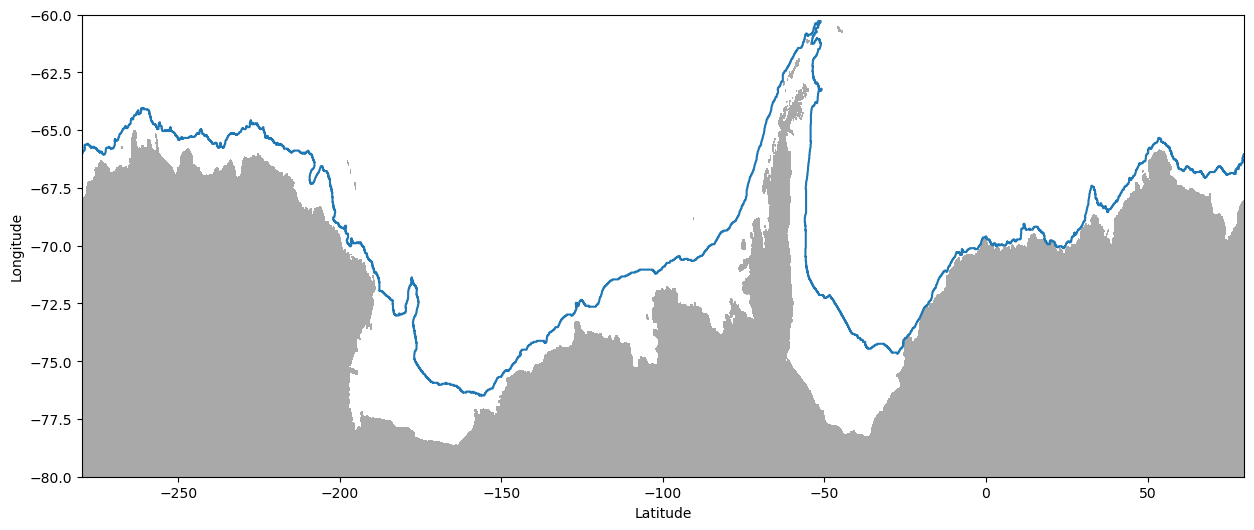

In [64]:
## Plot regions on antarctica ## USING 6002 CONTOUR INDEX
plt.figure(figsize = (15,6))
sc = plt.scatter(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0), c=labels_regional, cmap=CustomCmap_no3)
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.plot(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = -1))
plt.ylim([-80,-60])
plt.ylabel('Longitude')
plt.xlabel('Latitude')

In [57]:
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

In [38]:
CSHT_along.lon_bin_midpoints.size

1428

Text(0.5, 0, 'Latitude')

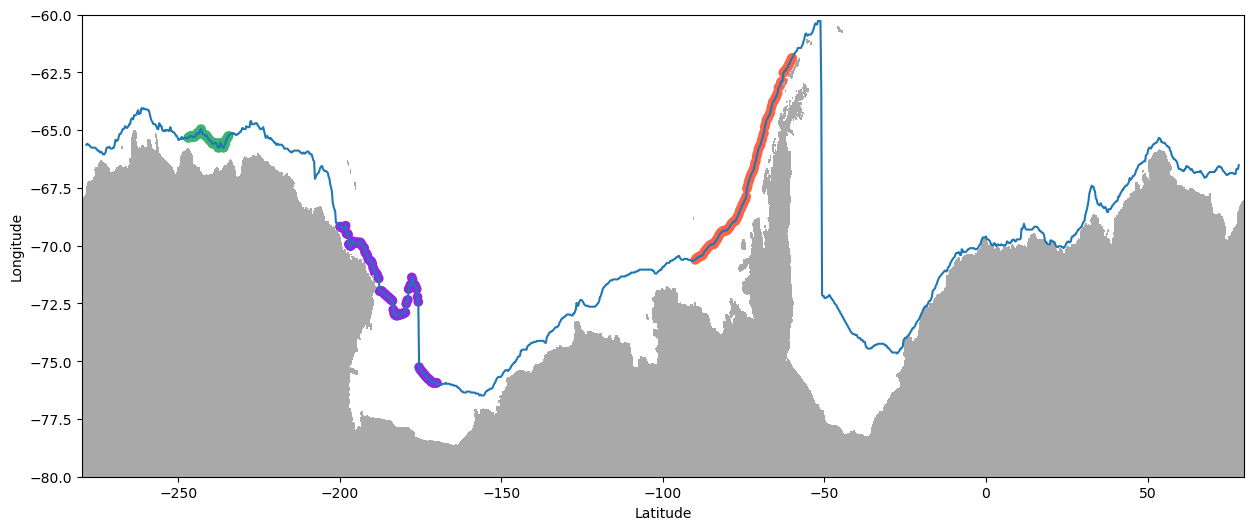

In [59]:
## Plot regions on antarctica

plt.figure(figsize = (15,6))
sc = plt.scatter(CSHT_along.lon_bin_midpoints, CSHT_along.lat_bin_midpoints.isel(time = 0, st_ocean = 0), c=labels_regional, cmap=CustomCmap_no3)
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.plot(CSHT_along.lon_bin_midpoints, CSHT_along.lat_bin_midpoints.isel(time = 0, st_ocean = -1))
plt.ylim([-80,-60])
plt.ylabel('Longitude')
plt.xlabel('Latitude')

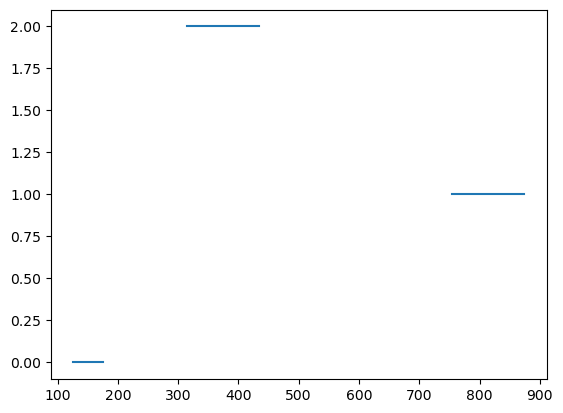

In [36]:
plt.plot(labels_regional)

## making mask and calculating correlations for daily data

In [11]:
## DAILY MASK
## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(u_along.u_along_contour_binned).shape[0], np.array(labels_regional).shape[0]))*np.nan
regions = ['Totten', 'WAP', 'Ross']

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_regional)==i, 1, np.nan)

clustering_mask_regional = xr.DataArray(labels_masks, dims = {'regions':np.arange(3).size, 'time':u_along.time.size, \
                                                     'lon_bin_midpoints':u_along.lon_bin_midpoints.size}, coords = {'regions': regions, 'time':u_along.time, \
                                                     'lon_bin_midpoints':u_along.lon_bin_midpoints})


"\nclustering_mask_regional = xr.DataArray(labels_masks, dims = {'regions':np.arange(3).size, 'time':u_along.time.size,                                                      'lon_along_contour':CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0).size}, coords = {'regions': regions, 'time':u_along.time,                                                      'lon_along_contour':CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0).values})\n                                                     "

In [12]:
## regional velocities
masked_u_along = u_along.rename({'st_ocean':'depth','lon_bin_midpoints': 'lon'}).chunk({'lon':50, 'depth': 25, 'time':4453})*clustering_mask_regional.rename({'lon_bin_midpoints': 'lon'})

In [13]:
masked_u_along= masked_u_along.chunk({'lon':50, 'depth': 25, 'time':4453})
masked_u_along

<xarray.Dataset>
Dimensions:                 (depth: 75, time: 22265, lon: 1428, regions: 3)
Coordinates:
  * depth                   (depth) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * time                    (time) datetime64[ns] 1958-01-01T12:00:00 ... 201...
  * lon                     (lon) float64 -278.5 -278.2 -278.0 ... 78.0 78.25
  * regions                 (regions) <U6 'Totten' 'WAP' 'Ross'
Data variables:
    u_along_contour_binned  (time, depth, lon, regions) float64 dask.array<chunksize=(4453, 25, 50, 3), meta=np.ndarray>
    lat_bin_midpoints       (time, lon, regions) float64 dask.array<chunksize=(4453, 50, 3), meta=np.ndarray>

In [14]:
## CSHT daily
CSHT_days = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*0.08).rename({'st_ocean':'depth'})
#CSHT_months_eddy = ((CSHT_along_eddy.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth'})

In [15]:
masked_CSHT = CSHT_days.rename({'lon_bin_midpoints':'lon'}).chunk({'lon':50, 'depth': 25, 'time':4453})*clustering_mask_regional.rename({'lon_bin_midpoints': 'lon'})
masked_CSHT

<xarray.DataArray (time: 22265, depth: 75, lon: 1428, regions: 3)>
dask.array<mul, shape=(22265, 75, 1428, 3), dtype=float64, chunksize=(4453, 25, 50, 3), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00
  * regions  (regions) <U6 'Totten' 'WAP' 'Ross'

In [16]:
import scipy.stats as stats

In [17]:
# load or it will take a long time
masked_CSHT.load()

<xarray.DataArray (time: 22265, depth: 75, lon: 1428, regions: 3)>
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00
  * regions  (regions) <U6 'Totten' 'WAP' 'Ross'

In [24]:
masked_u_along.load()

<xarray.Dataset>
Dimensions:                 (depth: 75, time: 22265, lon: 1428, regions: 3)
Coordinates:
  * depth                   (depth) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * time                    (time) datetime64[ns] 1958-01-01T12:00:00 ... 201...
  * lon                     (lon) float64 -278.5 -278.2 -278.0 ... 78.0 78.25
  * regions                 (regions) <U6 'Totten' 'WAP' 'Ross'
Data variables:
    u_along_contour_binned  (time, depth, lon, regions) float64 nan nan ... nan
    lat_bin_midpoints       (time, lon, regions) float64 nan nan nan ... nan nan

In [19]:
client.run(gc.collect)

{'tcp://127.0.0.1:38999': 56,
 'tcp://127.0.0.1:41891': 56,
 'tcp://127.0.0.1:43283': 56,
 'tcp://127.0.0.1:44153': 56}

In [24]:
masked_u_along_i = masked_u_along.isel(regions = 0).sel(lon = regional_bound[0])
masked_u_along_i

<xarray.Dataset>
Dimensions:                 (depth: 75, time: 22265, lon: 51)
Coordinates:
  * depth                   (depth) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * time                    (time) datetime64[ns] 1958-01-01T12:00:00 ... 201...
  * lon                     (lon) float64 -247.0 -246.8 -246.5 ... -234.8 -234.5
    regions                 <U6 'Totten'
Data variables:
    u_along_contour_binned  (time, depth, lon) float64 dask.array<chunksize=(4453, 25, 24), meta=np.ndarray>
    lat_bin_midpoints       (time, lon) float64 dask.array<chunksize=(4453, 24), meta=np.ndarray>

In [25]:
masked_CSHT_i = masked_CSHT.isel(regions = 0).sel(lon = regional_bound[0])
masked_CSHT_i

<xarray.DataArray (time: 22265, depth: 75, lon: 51)>
array([[[-1.73881396e+10, -1.89806123e+10, -1.76992643e+10, ...,
         -4.15356092e+09, -5.55079172e+09, -8.06597951e+09],
        [-1.83884559e+10, -1.95775424e+10, -1.82364786e+10, ...,
         -6.78841483e+09, -7.62679394e+09, -9.93594049e+09],
        [-1.91659626e+10, -1.98935321e+10, -1.84009012e+10, ...,
         -7.92615453e+09, -8.65540112e+09, -1.08498793e+10],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.84586777e+10, -1.88847345e+10, -2.01381236e+10, ...,
         -7.61442922e+09, -1.18092997e+10, -1.05720588e+10],
        [-1.86649405e+10, -1.87577441e+10, -2.00320496e+10, ...,
         -1.25738261e+10, -1.54902653e+10, -1.34706266e+10],
        [-1.87571306e+10, -1.81731295e+10, -1.92051361e+10, ...,
         -1.55067338e+10, -1.76652209e+10, -1.49474365e+10],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[-3.60565375e+09, -4.73497010e+09, -5.39459879e+09, ...,
         -7.52217489e+09, -1.43151202e+10, -1.07610138e+10],
        [-5.58326481e+09, -7.03231689e+09, -7.79699290e+09, ...,
         -1.68606656e+10, -2.30156953e+10, -1.88442083e+10],
        [-7.05681400e+09, -8.57509765e+09, -9.36477901e+09, ...,
         -2.36446810e+10, -2.93769943e+10, -2.46782309e+10],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -247.0 -246.8 -246.5 -246.2 ... -235.0 -234.8 -234.5
  * time     (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00
    regions  <U6 'Totten'

In [ ]:
%%time
print('loading')
## Average over different time scales to get depth-based correlations
CSHT_annual = masked_CSHT_i.mean('lon').groupby('time.year').mean('time').compute().values
print('...')

#CSHT_annual_eddy = masked_CSHT_eddy.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along_i.mean('lon').groupby('time.year').mean('time').compute().u_along_contour_binned.values
print('done annual')

print('loading')
CSHT_clima = masked_CSHT_i.groupby('time.month').mean('time').mean('lon').compute().values
#CSHT_clima_eddy = masked_CSHT_eddy.groupby('time.month').mean('time').mean('lon')
CSHT_clima

print('...')
U_along_clima = masked_u_along_i.groupby('time.month').mean('time').mean('lon').compute().u_along_contour_binned.values
print('done clima')

CSHT_layerwise = masked_CSHT_i.mean('lon').compute().values
print('...')
CSHT_layerwise

#CSHT_layerwise_eddy = masked_CSHT_eddy.mean('lon')
U_along_layerwise = masked_u_along_i.mean('lon').compute().u_along_contour_binned.values

In [62]:
print('loading')
CSHT_clima = masked_CSHT_i.groupby('time.dayofyear').mean('time').mean('lon').compute().values
#CSHT_clima_eddy = masked_CSHT_eddy.groupby('time.month').mean('time').mean('lon')
CSHT_clima

#print('...')
U_along_clima = masked_u_along_i.groupby('time.dayofyear').mean('time').mean('lon').compute().u_along_contour_binned.values
#print('done clima')

loading


<xarray.DataArray (dayofyear: 366, depth: 75)>
array([[-2.94223468e+09, -3.98178507e+09, -4.73595439e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.67309166e+09, -3.73918785e+09, -4.53742030e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.37606783e+09, -3.38134975e+09, -4.10642269e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.31824090e+09, -2.21884634e+09, -2.96397539e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.08661391e+09, -3.08514586e+09, -3.81992869e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.55395591e+09, -3.47112925e+09, -4.10506220e+09, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * depth      (depth) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    regions    <U6 'Ross'
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [61]:
client.run(gc.collect)

{'tcp://127.0.0.1:38999': 139,
 'tcp://127.0.0.1:41891': 139,
 'tcp://127.0.0.1:43283': 76,
 'tcp://127.0.0.1:44153': 139}

In [63]:
slope_all = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all = np.zeros((masked_u_along.depth.size, 3))
slope_annual = np.zeros((masked_u_along.depth.size, 3))
stderr_annual = np.zeros((masked_u_along.depth.size, 3))
r_sq_annual = np.zeros((masked_u_along.depth.size, 3))

slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))

## mod so it is full CSHT, not just eddies
for i in range(3):
    #select one region only to save compute
    masked_CSHT_i = masked_CSHT.isel(regions = i).sel(lon = regional_bound[i])
    masked_u_along_i = masked_u_along.isel(regions = i).sel(lon = regional_bound[i])
    
    client.run(gc.collect)
    ## Average over different time scales to get depth-based correlations
    CSHT_annual = masked_CSHT_i.mean('lon').groupby('time.year').mean('time').compute().values
    U_along_annual = masked_u_along_i.mean('lon').groupby('time.year').mean('time').compute().u_along_contour_binned.values
    print('done annual')
    client.run(gc.collect)
    CSHT_clima = masked_CSHT_i.groupby('time.dayofyear').mean('time').mean('lon').compute().values
    U_along_clima = masked_u_along_i.groupby('time.dayofyear').mean('time').mean('lon').compute().u_along_contour_binned.values
    print('done clima')
    client.run(gc.collect)
    CSHT_layerwise = masked_CSHT_i.mean('lon').compute().values
    U_along_layerwise = masked_u_along_i.mean('lon').compute().u_along_contour_binned.values
    print('done daily')
    client.run(gc.collect)
    
    for j in range(masked_u_along.depth.size):
        print(i, ', ', j)
        '''
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])], CSHT_layerwise_eddy[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])], CSHT_layerwise_eddy[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])], CSHT_layerwise_eddy[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])]/1e12).rvalue**2
        slope_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])], CSHT_annual_eddy[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])], CSHT_annual_eddy[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])]/1e12).stderr
        r_sq_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])], CSHT_annual_eddy[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])]/1e12).rvalue**2
        slope_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])], CSHT_clima_eddy[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])], CSHT_clima_eddy[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])], CSHT_clima_eddy[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])]/1e12).rvalue**2
        '''
        '''
        CSHT_layerwise_compute = ~np.isnan(CSHT_layerwise[:,j,i]).compute()
        CSHT_annual_compute = ~np.isnan(CSHT_annual[:,j,i]).compute()
        CSHT_clima_compute = ~np.isnan(CSHT_clima[:,j,i]).compute()
        '''
        CSHT_layerwise_compute = ~np.isnan(CSHT_layerwise[:,j])#.compute()
        CSHT_annual_compute = ~np.isnan(CSHT_annual[:,j])#.compute()
        CSHT_clima_compute = ~np.isnan(CSHT_clima[:,j])#.compute()
        
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j][CSHT_layerwise_compute], CSHT_layerwise[:,j][CSHT_layerwise_compute]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j][CSHT_layerwise_compute], CSHT_layerwise[:,j][CSHT_layerwise_compute]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j][CSHT_layerwise_compute], CSHT_layerwise[:,j][CSHT_layerwise_compute]/1e12).rvalue**2
        slope_annual[j,i] = stats.linregress(U_along_annual[:,j][CSHT_annual_compute], CSHT_annual[:,j][CSHT_annual_compute]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual[:,j][CSHT_annual_compute], CSHT_annual[:,j][CSHT_annual_compute]/1e12).stderr
        r_sq_annual[j,i] = stats.linregress(U_along_annual[:,j][CSHT_annual_compute], CSHT_annual[:,j][CSHT_annual_compute]/1e12).rvalue**2
        slope_clima[j,i] = stats.linregress(U_along_clima[:,j][CSHT_clima_compute], CSHT_clima[:,j][CSHT_clima_compute]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima[:,j][CSHT_clima_compute], CSHT_clima[:,j][CSHT_clima_compute]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima[:,j][CSHT_clima_compute], CSHT_clima[:,j][CSHT_clima_compute]/1e12).rvalue**2

done annual
done clima
done daily
0 ,  0
0 ,  1
0 ,  2
0 ,  3
0 ,  4
0 ,  5
0 ,  6
0 ,  7
0 ,  8
0 ,  9
0 ,  10
0 ,  11
0 ,  12
0 ,  13
0 ,  14
0 ,  15
0 ,  16
0 ,  17
0 ,  18
0 ,  19
0 ,  20
0 ,  21
0 ,  22
0 ,  23
0 ,  24
0 ,  25
0 ,  26
0 ,  27
0 ,  28
0 ,  29
0 ,  30
0 ,  31
0 ,  32
0 ,  33
0 ,  34
0 ,  35
0 ,  36
0 ,  37
0 ,  38
0 ,  39
0 ,  40
0 ,  41
0 ,  42
0 ,  43
0 ,  44
0 ,  45
0 ,  46
0 ,  47
0 ,  48
0 ,  49
0 ,  50
0 ,  51
0 ,  52
0 ,  53
0 ,  54
0 ,  55
0 ,  56
0 ,  57
0 ,  58
0 ,  59
0 ,  60
0 ,  61
0 ,  62
0 ,  63
0 ,  64
0 ,  65
0 ,  66
0 ,  67
0 ,  68
0 ,  69
0 ,  70
0 ,  71
0 ,  72
0 ,  73
0 ,  74
done annual
done clima
done daily
1 ,  0
1 ,  1
1 ,  2
1 ,  3
1 ,  4
1 ,  5
1 ,  6
1 ,  7
1 ,  8
1 ,  9
1 ,  10
1 ,  11
1 ,  12
1 ,  13
1 ,  14
1 ,  15
1 ,  16
1 ,  17
1 ,  18
1 ,  19
1 ,  20
1 ,  21
1 ,  22
1 ,  23
1 ,  24
1 ,  25
1 ,  26
1 ,  27
1 ,  28
1 ,  29
1 ,  30
1 ,  31
1 ,  32
1 ,  33
1 ,  34
1 ,  35
1 ,  36
1 ,  37
1 ,  38
1 ,  39
1 ,  40
1 ,  41
1 ,  42
1 ,  43


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


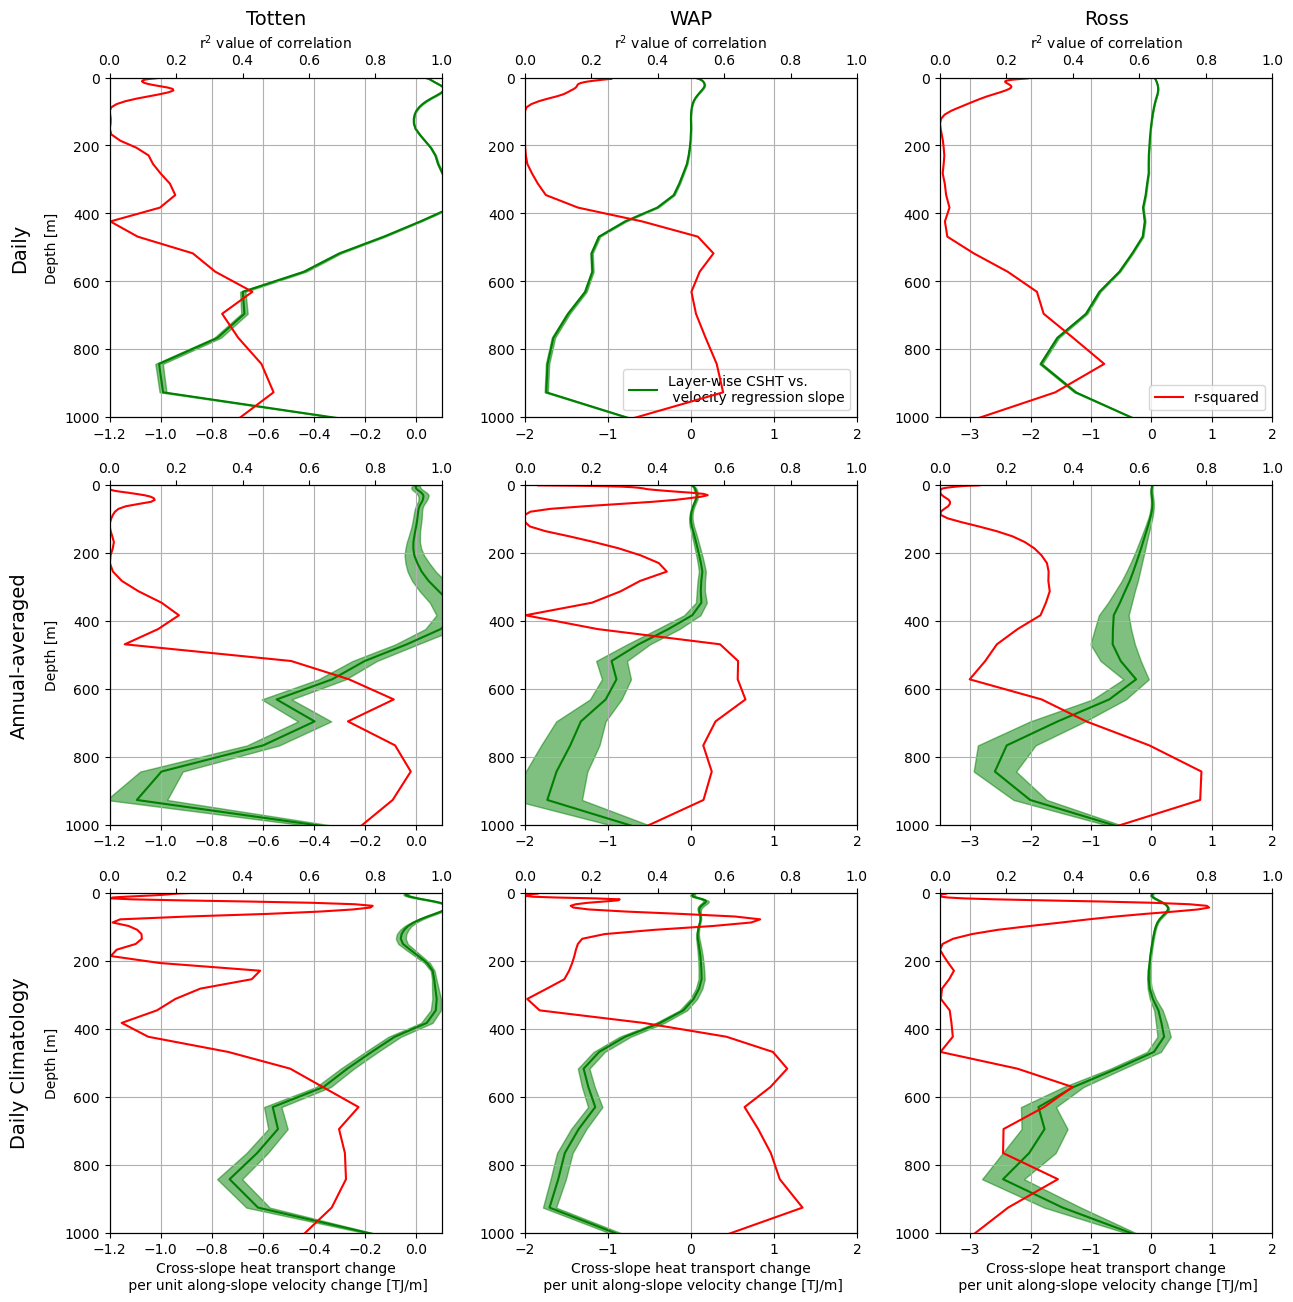

In [64]:
## DAILY DATA
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+3].fill_betweenx( masked_u_along.depth,  slope_annual[:,i]-stderr_annual[:,i]*2, slope_annual[:,i]+stderr_annual[:,i]*2, alpha=0.5, color='green')
    axs[i].plot(slope_all[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( masked_u_along.depth,  slope_all[:,i]-stderr_all[:,i]*2, slope_all[:,i]+stderr_all[:,i]*2, alpha=0.5, color='green')
    axs[i+6].plot(slope_clima[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(masked_u_along.depth, slope_clima[:,i]-stderr_clima[:,i]*2, slope_clima[:,i]+stderr_clima[:,i]*2, alpha=0.5, color='green')

    axs[i].set_title(regions[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_annual[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.2,0.1)
    axs[3*i+1].set_xlim(-2,2)
    axs[3*i+2].set_xlim(-3.5,2)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()
    axs[1].legend()

axs[0].text(-0.3,0.5, 'Daily', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Daily Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

ax1.legend(loc=4)
#plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Eddy_layer_wise_CSHT_vs_U_corr.png', bbox_inches='tight', dpi=300)
plt.show()

## making mask and calculating correlations for monthly data

In [12]:
## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(u_along_da_monthly).shape[0], np.array(labels_regional).shape[0]))*np.nan
regions = ['Totten', 'WAP', 'Ross']

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_regional)==i, 1, np.nan)

clustering_mask_regional = xr.DataArray(labels_masks, dims = {'regions':np.arange(3).size, 'time':u_along_da_monthly.time.size, \
                                                     'lon_bin_midpoints':u_along_da_monthly.lon_bin_midpoints.size}, coords = {'regions': regions, 'time':u_along_da_monthly.time, \
                                                     'lon_bin_midpoints':u_along_da_monthly.lon_bin_midpoints})

In [13]:
## regional velocities
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth','lon_bin_midpoints': 'lon'})*clustering_mask_regional.rename({'lon_bin_midpoints': 'lon'})

In [14]:
masked_u_along.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regions: 3)>
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regions  (regions) <U6 'Totten' 'WAP' 'Ross'

In [15]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth'})
CSHT_months_eddy = ((CSHT_along_eddy.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth'})

In [16]:
masked_CSHT = CSHT_months.rename({'lon_bin_midpoints':'lon'})*clustering_mask_regional.rename({'lon_bin_midpoints': 'lon'})
masked_CSHT_eddy = CSHT_months_eddy.rename({'lon_bin_midpoints':'lon'})*clustering_mask_regional.rename({'lon_bin_midpoints': 'lon'})
masked_CSHT

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regions: 3)>
dask.array<mul, shape=(732, 75, 1428, 3), dtype=float64, chunksize=(1, 75, 1428, 3), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regions  (regions) <U6 'Totten' 'WAP' 'Ross'

In [17]:
masked_CSHT.load()
masked_CSHT_eddy.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regions: 3)>
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regions  (regions) <U6 'Totten' 'WAP' 'Ross'

In [18]:
import gc
client.run(gc.collect)

{'tcp://127.0.0.1:35531': 3328,
 'tcp://127.0.0.1:36985': 3182,
 'tcp://127.0.0.1:37975': 2721,
 'tcp://127.0.0.1:39847': 3308}

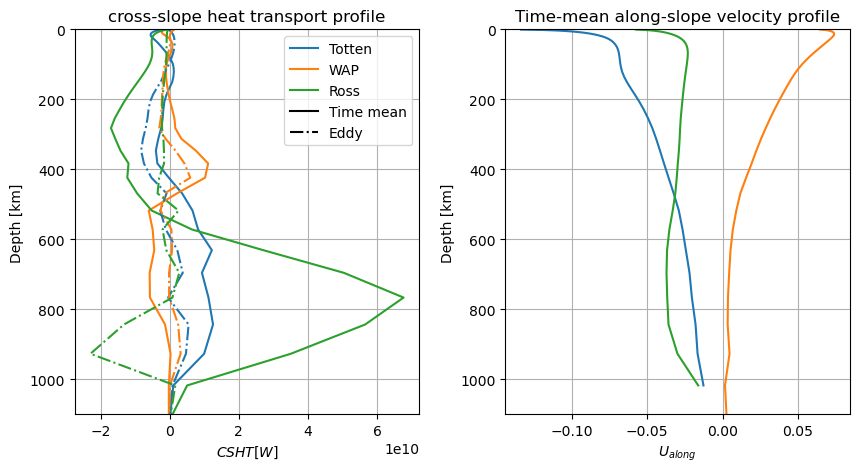

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT.isel(regions=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = regions[0])
masked_CSHT.isel(regions=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = regions[1])
masked_CSHT.isel(regions=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = regions[2])
axs[0].plot([0,0],[-10,-11],color='black',label='Time mean')
axs[0].plot([0,0],[-10,-11],'-.',color='black',label='Eddy')

masked_CSHT_eddy.isel(regions=0).mean('lon').mean('time').plot(ax=axs[0],linestyle='-.',color='tab:blue', y='depth')
masked_CSHT_eddy.isel(regions=1).mean('lon').mean('time').plot(ax=axs[0],linestyle='-.',color='tab:orange', y='depth')
masked_CSHT_eddy.isel(regions=2).mean('lon').mean('time').plot(ax=axs[0],linestyle='-.',color='tab:green', y='depth')


masked_u_along.groupby('time.month').mean('time').isel(regions=0).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = regions[0])
masked_u_along.groupby('time.month').mean('time').isel(regions=1).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = regions[1])
masked_u_along.groupby('time.month').mean('time').isel(regions=2).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = regions[2])

# (masked_CSHT.isel(regime=0).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=0).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[0])
# (masked_CSHT.isel(regime=1).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=1).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[1])
# (masked_CSHT.isel(regime=2).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=2).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[2])

# for j in range(3):
#     # Compute the power spectral density
#     frequencies, psd = signal.welch(masked_CSHT.isel(regime=j).mean('lon').mean('depth').values, fs=1)
#     axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('cross-slope heat transport profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_title('Time-mean along-slope velocity profile')
axs[1].set_ylim(1100,0)
axs[1].set_ylabel('Depth [km]')
axs[1].set_xlabel('$U_{along}$')

# axs[1].grid()
# axs[1].set_title('Depth-averaged cross-slope heat transport')
# axs[1].set_xlabel('Time')
# axs[1].set_ylabel('$CSHT [W]$')

# axs[2].set_title('Power Spectral Density ($CSHT$)')
# axs[2].set_xlabel('Period [Years]')
# axs[2].set_ylabel('Power')
# axs[2].set_xlim(2/12,20)
# axs[2].grid()
#plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/CSHT_vs_Ualong_time_mean.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
import scipy.stats as stats

In [ ]:
## Average over different time scales to get depth-based correlations

CSHT_annual = masked_CSHT.mean('lon').groupby('time.year').mean('time')
CSHT_annual_eddy = masked_CSHT_eddy.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along.mean('lon').groupby('time.year').mean('time')

CSHT_clima = masked_CSHT.groupby('time.month').mean('time').mean('lon')
CSHT_clima_eddy = masked_CSHT_eddy.groupby('time.month').mean('time').mean('lon')
U_along_clima = masked_u_along.groupby('time.month').mean('time').mean('lon')

CSHT_layerwise = masked_CSHT.mean('lon')
CSHT_layerwise_eddy = masked_CSHT_eddy.mean('lon')
U_along_layerwise = masked_u_along.mean('lon')

In [55]:
slope_all = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all = np.zeros((masked_u_along.depth.size, 3))
slope_annual = np.zeros((masked_u_along.depth.size, 3))
stderr_annual = np.zeros((masked_u_along.depth.size, 3))
r_sq_annual = np.zeros((masked_u_along.depth.size, 3))

slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))

## mod so it is full CSHT, not just eddies
for i in range(3):
    for j in range(masked_u_along.depth.size):
        print(i, ', ', j)
        '''
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])], CSHT_layerwise_eddy[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])], CSHT_layerwise_eddy[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])], CSHT_layerwise_eddy[:,j,i][~np.isnan(CSHT_layerwise_eddy[:,j,i])]/1e12).rvalue**2
        slope_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])], CSHT_annual_eddy[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])], CSHT_annual_eddy[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])]/1e12).stderr
        r_sq_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])], CSHT_annual_eddy[:,j,i][~np.isnan(CSHT_annual_eddy[:,j,i])]/1e12).rvalue**2
        slope_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])], CSHT_clima_eddy[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])], CSHT_clima_eddy[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])], CSHT_clima_eddy[:,j,i][~np.isnan(CSHT_clima_eddy[:,j,i])]/1e12).rvalue**2
        '''

        CSHT_layerwise_compute = ~np.isnan(CSHT_layerwise[:,j,i]).compute()
        CSHT_annual_compute = ~np.isnan(CSHT_annual[:,j,i]).compute()
        CSHT_clima_compute = ~np.isnan(CSHT_clima[:,j,i]).compute()
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][CSHT_layerwise_compute], CSHT_layerwise[:,j,i][CSHT_layerwise_compute]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][CSHT_layerwise_compute], CSHT_layerwise[:,j,i][CSHT_layerwise_compute]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][CSHT_layerwise_compute], CSHT_layerwise[:,j,i][CSHT_layerwise_compute]/1e12).rvalue**2
        slope_annual[j,i] = stats.linregress(U_along_annual[:,j,i][CSHT_annual_compute], CSHT_annual[:,j,i][CSHT_annual_compute]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual[:,j,i][CSHT_annual_compute], CSHT_annual[:,j,i][CSHT_annual_compute]/1e12).stderr
        r_sq_annual[j,i] = stats.linregress(U_along_annual[:,j,i][CSHT_annual_compute], CSHT_annual[:,j,i][CSHT_annual_compute]/1e12).rvalue**2
        slope_clima[j,i] = stats.linregress(U_along_clima[:,j,i][CSHT_clima_compute], CSHT_clima[:,j,i][CSHT_clima_compute]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima[:,j,i][CSHT_clima_compute], CSHT_clima[:,j,i][CSHT_clima_compute]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima[:,j,i][CSHT_clima_compute], CSHT_clima[:,j,i][CSHT_clima_compute]/1e12).rvalue**2

0 ,  0
0 ,  1
0 ,  2
0 ,  3
0 ,  4
0 ,  5
0 ,  6
0 ,  7
0 ,  8
0 ,  9
0 ,  10
0 ,  11
0 ,  12
0 ,  13
0 ,  14
0 ,  15
0 ,  16
0 ,  17
0 ,  18
0 ,  19
0 ,  20
0 ,  21
0 ,  22
0 ,  23
0 ,  24
0 ,  25
0 ,  26
0 ,  27
0 ,  28
0 ,  29
0 ,  30
0 ,  31
0 ,  32
0 ,  33
0 ,  34
0 ,  35
0 ,  36
0 ,  37
0 ,  38
0 ,  39
0 ,  40
0 ,  41
0 ,  42
0 ,  43
0 ,  44
0 ,  45
0 ,  46
0 ,  47
0 ,  48
0 ,  49
0 ,  50
0 ,  51
0 ,  52
0 ,  53
0 ,  54
0 ,  55
0 ,  56
0 ,  57
0 ,  58
0 ,  59
0 ,  60
0 ,  61
0 ,  62
0 ,  63
0 ,  64
0 ,  65
0 ,  66
0 ,  67
0 ,  68
0 ,  69
0 ,  70
0 ,  71
0 ,  72
0 ,  73
0 ,  74
1 ,  0
1 ,  1
1 ,  2
1 ,  3
1 ,  4
1 ,  5
1 ,  6
1 ,  7
1 ,  8
1 ,  9
1 ,  10
1 ,  11
1 ,  12
1 ,  13
1 ,  14
1 ,  15
1 ,  16
1 ,  17
1 ,  18
1 ,  19
1 ,  20
1 ,  21
1 ,  22
1 ,  23
1 ,  24
1 ,  25
1 ,  26
1 ,  27
1 ,  28
1 ,  29
1 ,  30
1 ,  31
1 ,  32
1 ,  33
1 ,  34
1 ,  35
1 ,  36
1 ,  37
1 ,  38
1 ,  39
1 ,  40
1 ,  41
1 ,  42
1 ,  43
1 ,  44
1 ,  45
1 ,  46
1 ,  47
1 ,  48
1 ,  49
1 ,  50
1 ,  51
1 , 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


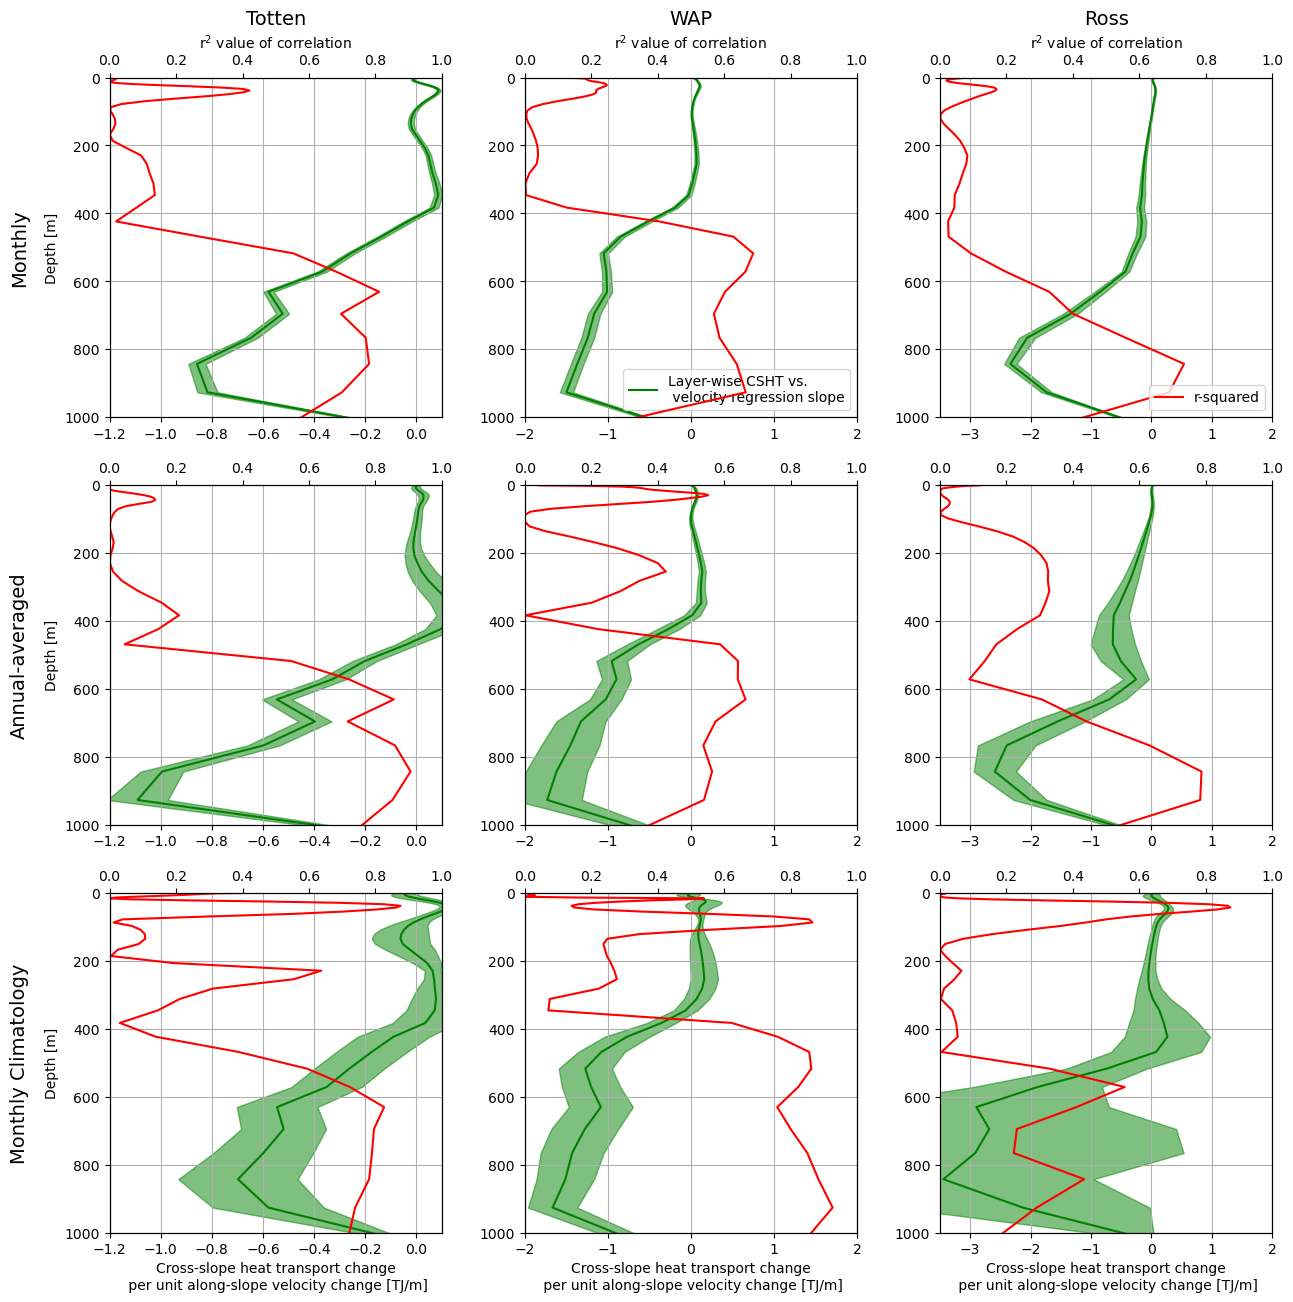

In [70]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3):
    axs[i+3].plot(slope_annual[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+3].fill_betweenx( masked_u_along.depth,  slope_annual[:,i]-stderr_annual[:,i]*2, slope_annual[:,i]+stderr_annual[:,i]*2, alpha=0.5, color='green')
    axs[i].plot(slope_all[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( masked_u_along.depth,  slope_all[:,i]-stderr_all[:,i]*2, slope_all[:,i]+stderr_all[:,i]*2, alpha=0.5, color='green')
    axs[i+6].plot(slope_clima[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+6].fill_betweenx(masked_u_along.depth, slope_clima[:,i]-stderr_clima[:,i]*2, slope_clima[:,i]+stderr_clima[:,i]*2, alpha=0.5, color='green')

    axs[i].set_title(regions[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+3].twiny()
    ax3 = axs[i+6].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value of correlation')
    ax1.plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_annual[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    axs[0].set_ylabel('Depth [m]')
    axs[3].set_ylabel('Depth [m]')
    axs[6].set_ylabel('Depth [m]')

    axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[3*i].set_xlim(-1.2,0.1)
    axs[3*i+1].set_xlim(-2,2)
    axs[3*i+2].set_xlim(-3.5,2)

    axs[i].grid()
    axs[i+3].invert_yaxis()
    axs[i+3].set_ylim(1000,0)
    axs[i+3].grid()
    axs[i+6].invert_yaxis()
    axs[i+6].set_ylim(1000,0)
    axs[i+6].grid()
    axs[1].legend()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

ax1.legend(loc=4)
#plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/Eddy_layer_wise_CSHT_vs_U_corr.png', bbox_inches='tight', dpi=300)
plt.show()